In [3]:
import cv2
import glob
import matplotlib.pyplot as plt
import random
from random import randint
from pathlib import Path
import pandas as pd
import numpy as np
from sklearn import preprocessing
import tensorflow as tf
from tensorflow.keras import layers
import os

print(tf.version.VERSION)
print(tf.keras.__version__)

1.14.0
2.2.4-tf


In [4]:
train_dir = 'chest-xray-pneumonia/chest_xray/train'
test_dir =  'chest-xray-pneumonia/chest_xray/test'
X = []
Y = []


for fileName in os.listdir(train_dir + "/NORMAL"): 
        img = cv2.imread(train_dir + "/NORMAL/" + fileName)
        if img is not None:
            Y.append(0)
            img = cv2.resize(img,(64,64))
            X.append(img)
    
for fileName in os.listdir(train_dir + "/PNEUMONIA"): 
        img = cv2.imread(train_dir + "/PNEUMONIA/" + fileName)
        if img is not None:
            Y.append(1)
            img = cv2.resize(img,(64,64))
            X.append(img)
            
for fileName in os.listdir(test_dir + "/NORMAL"): 
        img = cv2.imread(test_dir + "/NORMAL/" + fileName)
        if img is not None:
            Y.append(0)
            img = cv2.resize(img,(64,64))
            X.append(img)
    
for fileName in os.listdir(test_dir + "/PNEUMONIA"): 
        img = cv2.imread(test_dir + "/PNEUMONIA/" + fileName)
        if img is not None:
            Y.append(1)
            img = cv2.resize(img,(64,64))
            X.append(img)

Patient with Pneumonia:


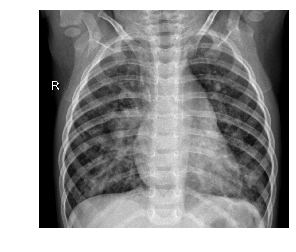

In [5]:
print("Patient with Pneumonia:")
pneumonia = cv2.imread(test_dir + "/PNEUMONIA/person15_virus_46.jpeg")
plt.axis('off')
plt.imshow(pneumonia)

Patient without pneumonia:


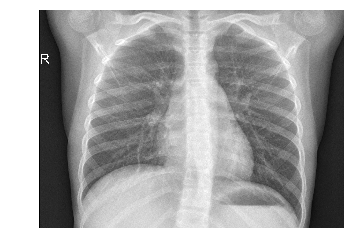

In [6]:
print("Patient without pneumonia:")
normal = cv2.imread(test_dir + "/NORMAL/IM-0003-0001.jpeg")
plt.axis('off')
plt.imshow(normal)

In [7]:
normal.shape

(1509, 2111, 3)

### Data Normalization

First we need to normalize the data. As pixels in images can only range from 0 to 255 we divide by 255 as it is the maximum value.

Our labels can only take two values: 0 if the patient is not diagnosed with pneumonia, 1 if the patient is diagnosed with pneumonia. This values are loaded as strings so we need to transform them into integers. 

### Problem to solve 

Having said this, it is not hard to see that we are solving a binary classification problem. We will train a convolutional neural network to predict the probability of a patient of having pneumonia. Binary cross entropy will be used as our cost function. 

In [8]:
X = np.array(X)/255
X = (X - np.average(X,0))/np.std(X,0)

In [9]:
Y = np.array(Y)
Y = Y.astype(int)

### Splitting Data 

We will partition our dataset into training, test and validation datasets. 

In [10]:
from sklearn.model_selection import train_test_split
X_train, X_test_validation, y_train, y_test_validation = train_test_split(X, Y,
                                                    stratify=Y, 
                                                    test_size=0.4)

In [11]:
X_validation, X_test, y_validation, y_test = train_test_split(X_test_validation, y_test_validation,
                                                    stratify=y_test_validation, 
                                                    test_size=0.5)

In [12]:
print("Training set: ", X_train.shape)
print("Test set: ",X_test.shape)
print("Validation set: ",X_validation.shape)

Training set:  (3504, 64, 64, 3)
Test set:  (1168, 64, 64, 3)
Validation set:  (1168, 64, 64, 3)


## Defining the Convolutional Neural Networks

In [13]:
img_width = X_train.shape[1]
img_height = X_train.shape[2]

### Experiment 1:
* input layer with 32 filters of 3x3.
* 2 hidden layers, each with 64 neurons.
* Max pooling between each hidden layer.
* adam optimizer.
* data is fed in a single batch.



In [14]:
model = tf.keras.Sequential()
model.add(layers.Convolution2D(32,(3,3), input_shape=(img_width,img_height,3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))

###classification layer
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 62, 62, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 29, 29, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 12, 12, 64)        36928     
_________________________________________________________________
flatten (Flatten)            (None, 9216)              0         
_________________________________________________________________
dense (Dense)                (None, 64)                5

In [16]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.fit(X_train, y_train, epochs=5)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Epoch 1/5


UnknownError: 2 root error(s) found.
  (0) Unknown: Failed to get convolution algorithm. This is probably because cuDNN failed to initialize, so try looking to see if a warning log message was printed above.
	 [[{{node conv2d/Conv2D}}]]
  (1) Unknown: Failed to get convolution algorithm. This is probably because cuDNN failed to initialize, so try looking to see if a warning log message was printed above.
	 [[{{node conv2d/Conv2D}}]]
	 [[metrics/acc/Identity/_105]]
0 successful operations.
0 derived errors ignored.

In [ ]:
score = model.evaluate(X_test, y_test)

This model performed really well. However, training time took a while. This is due to the fact that a single batch was inserted for each epoch.

### Experiment 2:
* 2 hidden layers, each with 64 neurons.
* Max pooling between each hidden layer.
* adam optimizer.
* data is fed in mini batches of size 32.



In [ ]:
model_2 = model

In [ ]:
model_2.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model_2.fit(X_train, y_train, epochs=5, batch_size = 32)

In [ ]:
score_2 = model_2.evaluate(X_test, y_test)

In [ ]:
score_2 = model_2.evaluate(X_validation, y_validation)

## Hidden layers as intermediate representations

Working with images is a great opportunity to visualize hidden layers of our convolutional network. These hidden layers represent the feature maps and how the convolutional neural network is training activations and thus decomposing the input images through these filters. 

First we need to define a model that has as output the hidden layers and representations. Then, we will pass an image to the model in order to plot the resulting activations.

In [ ]:
layer_outputs = [layer.output for layer in model.layers[:8]] 
activation_model = tf.keras.models.Model(inputs=model.input, outputs=layer_outputs) 

In [ ]:
activation_model

### Make a prediction using the activation model

We will import an image to be used as an example for our activation model layers. 

<img src ="chest-xray-pneumonia/chest_xray/test/PNEUMONIA/person15_virus_46.jpeg" width="400">

In [ ]:
image = cv2.imread(test_dir + "/PNEUMONIA/person15_virus_46.jpeg")
image = cv2.resize(image,(64,64))
image = image.reshape(1,64,64,3)

In [ ]:
image.shape

In [ ]:
activations = activation_model.predict(image)

In [ ]:
first_layer_activation =np.array(activations[0])

In [ ]:
first_layer_activation.shape

In [ ]:
channels = first_layer_activation.shape[3]
i = 0
while i < channels:
    plt.matshow(first_layer_activation[0, :, :,i], cmap='viridis')
    i+=1

In [ ]:
second_layer_activation =np.array(activations[1])
channels = second_layer_activation.shape[3]
i = 1
while i < channels:
    plt.matshow(first_layer_activation[0, :, :,i], cmap='viridis')
    i+=1

In [28]:
X.shape

(5840, 64, 64, 3)